In [1]:
import os
import re
import numpy as np
import h5py
import datetime
import pickle

import SB_support
import process_files
import process_others
import var_use

In [2]:
path = "../../0 original data/SeaBASS HPLC/"
files = os.listdir(path)
print(len(files))

1393


In [3]:
# 利用read_file.readSB读取数据，之后把数据交给read_content整理和提取
# 文件保存到 txts 列表

txts = []
units = []
count1, count2 = 0, 0 # 分别为总数据条数，提取的数据条数
for file in files:
    # 读取并保存
    file_obj = SB_support.readSB(path+file,no_warn=True)
    txt = process_files.read_content(file_obj)

    txts.append(txt)
    length = txt.length
    count1 +=length
    unit = (txt.variables["fuco"][1]) if "fuco" in txt.variables else txt.variables["zea"][1]
    if "fuco" not in [item.lower() for item in txt.data]: print(file)
    if unit not in units: units.append(unit)
print("total availiable data: {:d}".format(count1))

6e07c49506_CFL_2008-9_HPLC.sb
total availiable data: 41312


In [4]:
# os.remove("../../0 original data/SeaBASS HPLC/desktop.ini")

In [5]:
lats,lons,depths,dates = [],[],[],[]
data = {var:np.array([]) for var in list(var_use.var_use_names)}

files = []
for count,txt in enumerate(txts):
    # 记录文件名
    for i in range(txt.length): files.append(txt.filename.split("/")[-1])
    # 时间
    if txt.time is not None:
        for t in txt.time: dates.append(t)
    else:
        for t in process_others.revise_time(txt,var_use.var_time): dates.append(t)
    # 经纬度
    lats = np.append(lats, process_others.revise_lat(txt,var_use.var_lat))
    lons = np.append(lons, process_others.revise_lon(txt,var_use.var_lon))
    # 深度
    depths = np.append(depths, process_others.revise_depth(txt,var_use.var_depth))  
        
    for var in var_use.var_use_names:
        if txt.is_exist(var_use.var_use_names[var]):
            tmp = np.double(txt.get_var(var_use.var_use_names[var]))
            tmp = np.sum(tmp,axis=0)
            data[var] = np.append( data[var], tmp )
        else:
            data[var] = np.append( data[var], np.nan*np.zeros(txt.length) )
    
lons, lats, depths = np.array(lons), np.array(lats), np.array(depths)

In [6]:
for var in list(data): print(var,data[var].shape,sum(~np.isnan(data[var])),end="\t")
print("dates", len(dates),"lon",len(lons),"lat",len(lats),"depth",len(depths))

print("\n 提取所有数据:{:}".format( len(dates)) )

fuco (41312,) 39175	perid (41312,) 36606	hex_fuco (41312,) 37597	but_fuco (41312,) 36109	allo (41312,) 35769	tchl_b (41312,) 22567	zea (41312,) 36986	tchl_a (41312,) 31082	diato (41312,) 32409	diadino (41312,) 37029	mv_chl_a (41312,) 16701	mv_chl_b (41312,) 13884	dv_chl_a (41312,) 23253	dv_chl_b (41312,) 16899	chl_c12 (41312,) 31955	chl_c3 (41312,) 32113	neo (41312,) 23570	viola (41312,) 26029	lut (41312,) 25864	pras (41312,) 25978	chl_a (41312,) 19788	chlide_a (41312,) 30635	gyro (41312,) 9962	phytin_a (41312,) 24041	dates 41312 lon 41312 lat 41312 depth 41312

 提取所有数据:41312


In [7]:
with open("../../0 save inner data/1 read SeaBASS HPLC.pkl", 'wb') as f:
    pickle.dump([dates, lons, lats, depths, data], f)


In [8]:
with open("../../0 save data/read SeaBASS HPLC.txt",'w') as f:
    write_str = "date time"+"\t"+"lat"+"\t"+"lon"+"\t"+"depth"+"\t"
    for var in data:write_str = write_str+var+"\t"
    f.write(write_str+"\n")
    for i in range(len(lats)):
        write_str = str(dates[i])+"\t"+str(lats[i])+"\t"+str(lons[i])+"\t"+str(depths[i])+"\t"
        for var in data: write_str = (write_str+str(data[var][i])+"\t") if data[var][i]==data[var][i] else (write_str+str(-999)+"\t")
        f.write(write_str+"\n")

In [9]:
for var in data:
    with open(f"../../fornext/HPLC[{var}]_(SeaBASS).txt",'w') as f:
        f.write("date time"+"\t"+"lat"+"\t"+"lon"+"\t"+"depth (m)"+"\t"+var+" (mg/m^3)\n")
        for i in range(len(lats)):
            if (data[var][i]>0.0005):
                write_str = f"{dates[i]}\t{lats[i]:.4f}\t{lons[i]:.4f}\t{depths[i]:.1f}\t{data[var][i]:.4f}"
                f.write(write_str+"\n")

In [10]:
list(data)

['fuco',
 'perid',
 'hex_fuco',
 'but_fuco',
 'allo',
 'tchl_b',
 'zea',
 'tchl_a',
 'diato',
 'diadino',
 'mv_chl_a',
 'mv_chl_b',
 'dv_chl_a',
 'dv_chl_b',
 'chl_c12',
 'chl_c3',
 'neo',
 'viola',
 'lut',
 'pras',
 'chl_a',
 'chlide_a',
 'gyro',
 'phytin_a']

Text(0, 0.5, 'count')

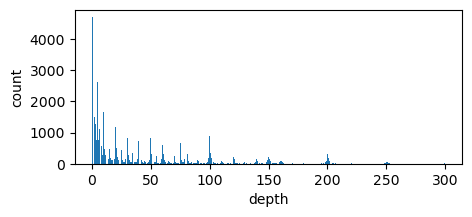

In [11]:
import matplotlib.pyplot as plt
dep = np.array(depths)
count = []
for i in range(300):
    count.append((dep<=i).sum())
count = np.array(count)

plt.figure(figsize=(5,2))
plt.bar(range(1,300),count[1:]-count[:-1])
plt.xlabel("depth")
plt.ylabel("count")